In [133]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Exploratory analysis for SMEs in HCMC"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

AIM: 
- explore data to refine questions about data
- search for answers by visual comparisons and transformations


In [134]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import mplleaflet as mpl

import utils_processing

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))
sns.set_style('darkgrid')

<Figure size 2000x1000 with 0 Axes>

In [159]:
# load cleaned survey data
from shapely import wkt

df_candidates = pd.read_excel("../input_survey_data/input_data_business_ex.xlsx") #survey_data_candidates_coords.xlsx")


df_candidates['geometry'] = df_candidates['geometry'].apply(wkt.loads)

df_candidates = gpd.GeoDataFrame(df_candidates, crs='epsg:4326')
## workaround: fix flip of coordinates to lon, lat
df_candidates = gpd.GeoDataFrame(df_candidates, 
        geometry=gpd.points_from_xy(df_candidates.geometry.y, df_candidates.geometry.x)#.split(",")[0], df_candidates.GPS.split(",")[1])
)

print(df_candidates.crs)
df_candidates.head(5)

epsg:4326


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,flood_year,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,geometry,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_suppliers_location.1,shp_suppliers_location.2,shp_suppliers_location.3,shp_suppliers_location.4,shp_suppliers_location.5,shp_profits_last5years,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,id,shp_building_value_euro,shp_content_value_euro,shp_registered_capital_euro,shp_content_value_mVND,elevation_m
0,0.0,0.0,2.0,10.0,1,0,0,0,0,2,3.0,0,0,0,0,0,0,0,1,1,5,5,5,4,5,5,5,5,2015.0,80.0,1,12.0,25.0,POINT (10.79648 106.69897),2.0,3,17,1,2,1,1,0,0,0,0,4.0,1.0,1.0,5.0,2.0,5.0,5.0,1.0,2,5.0,2.0,1.0,3.0,3.0,3.0,0.0,1841.3,1841.3,184.1,NaN,1.72359
1,0.0,0.0,2.0,15.0,0,1,0,0,0,2,NaN,0,0,0,0,0,0,0,1,1,5,5,5,4,5,5,5,5,2017.0,70.0,1,0.0,21.0,POINT (10.79652 106.69891),3.0,3,22,1,2,1,0,1,0,0,0,4.0,1.0,1.0,5.0,1.0,5.0,5.0,1.0,1,5.0,2.0,3.0,1.0,1.0,NaN,1.0,1841.3,1841.3,368.3,NaN,1.18550
2,0.0,0.0,1.0,2.0,1,0,0,0,0,2,NaN,0,0,0,0,0,0,0,1,1,1,5,1,1,5,1,5,5,2020.0,50.0,1,21.0,50.0,POINT (10.79754 106.70081),4.0,1,31,1,1,1,1,0,0,0,0,3.0,1.0,1.0,4.0,1.0,2.0,4.0,2.0,4,4.0,2.0,3.0,1.0,3.0,3.0,2.0,16571.5,16571.5,368.3,NaN,1.66465
3,0.0,NaN,3.0,10.0,1,0,0,0,0,1,8.0,0,0,0,0,0,0,0,1,1,1,1,5,5,5,1,5,3,2020.0,NaN,1,20.0,25.0,POINT (10.79757 106.70107),2.0,1,11,1,1,1,1,0,0,0,0,3.0,1.0,1.0,5.0,4.0,1.0,5.0,1.0,5,5.0,1.0,2.0,3.0,3.0,2.0,3.0,7365.1,7365.1,NaN,NaN,1.49934
4,0.0,0.0,3.0,5.0,0,1,0,0,1,3,NaN,0,0,0,0,0,0,0,1,1,5,5,5,1,5,1,5,3,2020.0,10.0,1,20.0,80.0,POINT (10.79742 106.70010),3.0,1,11,1,1,1,1,0,0,0,0,2.0,1.0,1.0,5.0,3.0,1.0,5.0,2.0,5,5.0,1.0,2.0,3.0,3.0,2.0,4.0,16571.5,16571.5,36.8,NaN,1.65202


## Exploratory data analysis


### Map spatial distribution of interviewed businesses
Explore interactively selection of important predictors and targets 

In [161]:
#sm = df_candidates[["Target_contentloss_euro", "Target_businessreduction", "inundation_duration_h", "water_depth_cm", "geometry"]]
sm = df_candidates[["Target_contentloss_euro", "Target_businessreduction", "inundation_duration_h", "water_depth_cm", "geometry"]]
sm = sm[~ sm.is_empty]   # drop emtpy geoms
sm.explore("water_depth_cm", cmap="cool")

In [162]:
df_candidates_y = df_candidates[["Target_contentloss_euro", "Target_businessreduction"]]
df_candidates_X = df_candidates.drop(["Target_contentloss_euro", "Target_businessreduction"], axis=1)

# fig, ax_hist = plt.subplots(len(df_targets.columns), 1, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})

# #for i, c in enumerate(df_targets.columns[:]):
#     #plt.subplots_adjust(hspace=.2)
# #sns.boxplot(x=df_targets.astype(float), showfliers=True, ax=ax_hist[0]).set(title=f"", xlabel=None)
# sns.histplot(x=df_targets.astype(float), stat='count', ax=ax_hist[1]).set(title=" ", xlabel=None) # bins=12, stat="percent"


In [163]:
#df_candidates.shp_registered_capital_mVND[df_candidates.Target_contentloss_euro!=0.0].describe()

# content loss for HCMC 137euro (mean:2242) when all non-damages are removed
# shp_registered_capital_mVND

### count 0 and missing values for each predictor

In [164]:
df_candidates.isna().sum().sort_values()[-20:]# count also np.nan


resilience_city_protection                      15
resilience_more_future_affected                 15
shp_monetary_resources4prevention               18
resilience_govern_warnings_helpful              18
resilience_govern_careing                       23
hh_monthly_income_cat                           24
perception_private_economy_future               26
bage                                            27
shp_risk_tolerance                              28
perception_who_responsible4protection.Rank1     28
Target_businessreduction                        36
shp_registered_capital_euro                     47
resilience_govern_careing_increases             54
shp_building_value_euro                         62
shp_content_value_euro                          62
elevation_building_height_cm                    63
perception_govern_support_future               136
perception_govern_support_past                 152
perception_who_responsible4protection.Rank2    156
warning_time_h                 

In [165]:
## count zeros
df_candidates[df_candidates==0].count().sort_values()[-25:]


id                                 1
bage                              11
overall_problem_house             41
contaminations.1                  43
shp_finance_investments           57
emergency_measures.3             127
Target_businessreduction         149
shp_suppliers_location.1         156
shp_suppliers_location.2         156
elevation_rel2surrounding_cat    159
contaminations.4                 173
emergency_measures.4             192
Target_contentloss_euro          226
emergency_measures.1             233
emergency_measures.2             235
emergency_measures.7             251
emergency_measures.6             267
emergency_measures.9             348
contaminations.0                 361
contaminations.2                 370
shp_suppliers_location.3         376
emergency_measures.8             381
contaminations.3                 387
shp_suppliers_location.4         393
shp_suppliers_location.5         395
dtype: int64

In [166]:
## drop columns with too many missing information
#df_sm = df_candidates.drop(df_candidates.filter(regex="^warning_type*|perception_who_responsible4protection.Rank1|perception_who_responsible4protection.Rank2|perception_who_responsible4protection.Rank5|perception_who_responsible4protection.Rank6|perception_who_responsible4protection.Rank7|perception_who_responsible4protection.Rank88"), axis=1)


Many shops reported no direct losses as well as no indirect losses expressed as business reudction. While missing information about the direct and indirect losses is seldom

## Correlation between variables by Pearson Correlation Coefficient

Identify canidates for the predicand "direct costs for damages of buiness contents" using Pearson Correlation Coefficient

In [167]:
#df_sm["overall_problem_house.3"].value_counts();

In [168]:
df_sm = df_candidates#.drop(df_candidates.filter(regex="^warning_type*|^main_causes*|perception_who_responsible4protection.Rank1|perception_who_responsible4protection.Rank2|perception_who_responsible4protection.Rank5|perception_who_responsible4protection.Rank6|perception_who_responsible4protection.Rank7|perception_who_responsible4protection.Rank88"), axis=1)
print(df_sm.shape)
df_sm.columns[:]

(397, 65)


Index(['Target_contentloss_euro', 'Target_businessreduction',
       'inundation_duration_h', 'water_depth_cm', 'contaminations.0',
       'contaminations.1', 'contaminations.2', 'contaminations.3',
       'contaminations.4', 'flowvelocity', 'warning_time_h',
       'emergency_measures.1', 'emergency_measures.2', 'emergency_measures.3',
       'emergency_measures.4', 'emergency_measures.6', 'emergency_measures.7',
       'emergency_measures.8', 'emergency_measures.9', 'overall_problem_house',
       'protect_valuables_impl', 'water_barriers_impl',
       'pumping_equipment_impl', 'elevation_building_impl',
       'resistant_material_building_impl', 'electricity_higher_impl',
       'flood_protections_impl', 'flood_experience', 'flood_year',
       'elevation_building_height_cm', 'elevation_rel2surrounding_cat', 'bage',
       'b_area', 'geometry', 'hh_monthly_income_cat', 'shp_owner',
       'shp_sector', 'shp_employees', 'shp_avgmonthly_sale_cat',
       'shp_finance_investments', 'sh

In [169]:
# # df_sm.iloc[:, 55:68].count()#.corr(method=lambda x, y: pearsonr(x, y)[1]) 
# # #.drop(columns=['flood_time', 'same', 'lat', 'lon', 'geometry'
# # #         #'shp_damage_level_others', 'insurance_business'
# # #         ], axis=1)
# # df_sm.filter(regex="_impl", axis=1).value_counts()


# precaut = df_sm.filter(regex="_impl", axis=1)
# precaut
# # df_sm = pd.concat([df_sm[["Target_direct", "business_reduction", "rloss_1", "rloss_2"]], precaut], axis=1
df_sm.b_area.describe()

count     395.000000
mean       89.102532
std        97.899512
min        12.000000
25%        42.000000
50%        74.000000
75%       100.000000
max      1000.000000
Name: b_area, dtype: float64

In [170]:
## Code snippet : https://stackoverflow.com/questions/69900363/colour-statistically-non-significant-values-in-seaborn-heatmap-with-a-different


def plot_pearsoncorrelation(df_sm_corr, signif=True, psig=0.05):
        """
        df_sm_corr (dataframe): dataframe with variables to plot
        signifcance (boolean): should non significant be masked
        psig (float): signifcance level
        return: Figure for Pearson Correlation 
        """ 
        
        ## get the p value for pearson coefficient, subtract 1 on the diagonal
        pvals = df_sm_corr.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*df_sm_corr.corr().shape)
        psig = 0.05  # 5% signif level

        #plt.figure(figsize=(5,5))
        plt.figure(figsize=(18,18))

        #sns.heatmap(df_sm.corr()[pvals<psig], annot=False, square=False, cmap="YlOrRd", fmt=".2f", zorder=1)
        sns.heatmap(df_sm_corr.corr(), annot=False, square=True, cmap="RdBu", fmt=".2f", zorder=1)

        if signif == True:
                ## add another heatmap with colouring the non-significant cells
                sns.heatmap(df_sm_corr.corr()[pvals>=psig], annot=False, square=True, cbar=False, 
        cmap=sns.color_palette("Greys", n_colors=1, desat=1),  zorder = 2) #put the map above the heatmap
        ## add a label for the colour
        colors = [sns.color_palette("Greys", n_colors=1, desat=1)[0]]
        texts = [f"not significant (at {psig})"]
        patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
        plt.legend(handles=patches, bbox_to_anchor=(.85, 1.05), loc='center')


In [171]:
#df_sm_corr.shp_closed_d.describe(
#df_sm.filter(regex="2",axis=1)#[df_sm_corr.shp_closed_d==0.0]#.sum()  # 78, 222, 231=shp_closed_d


In [172]:
df_sm.water_barriers_impl.value_counts()

water_barriers_impl
5    188
1    158
4     39
2     12
Name: count, dtype: int64

In [173]:
#df_sm= df_sm.replace(" ", np.nan)

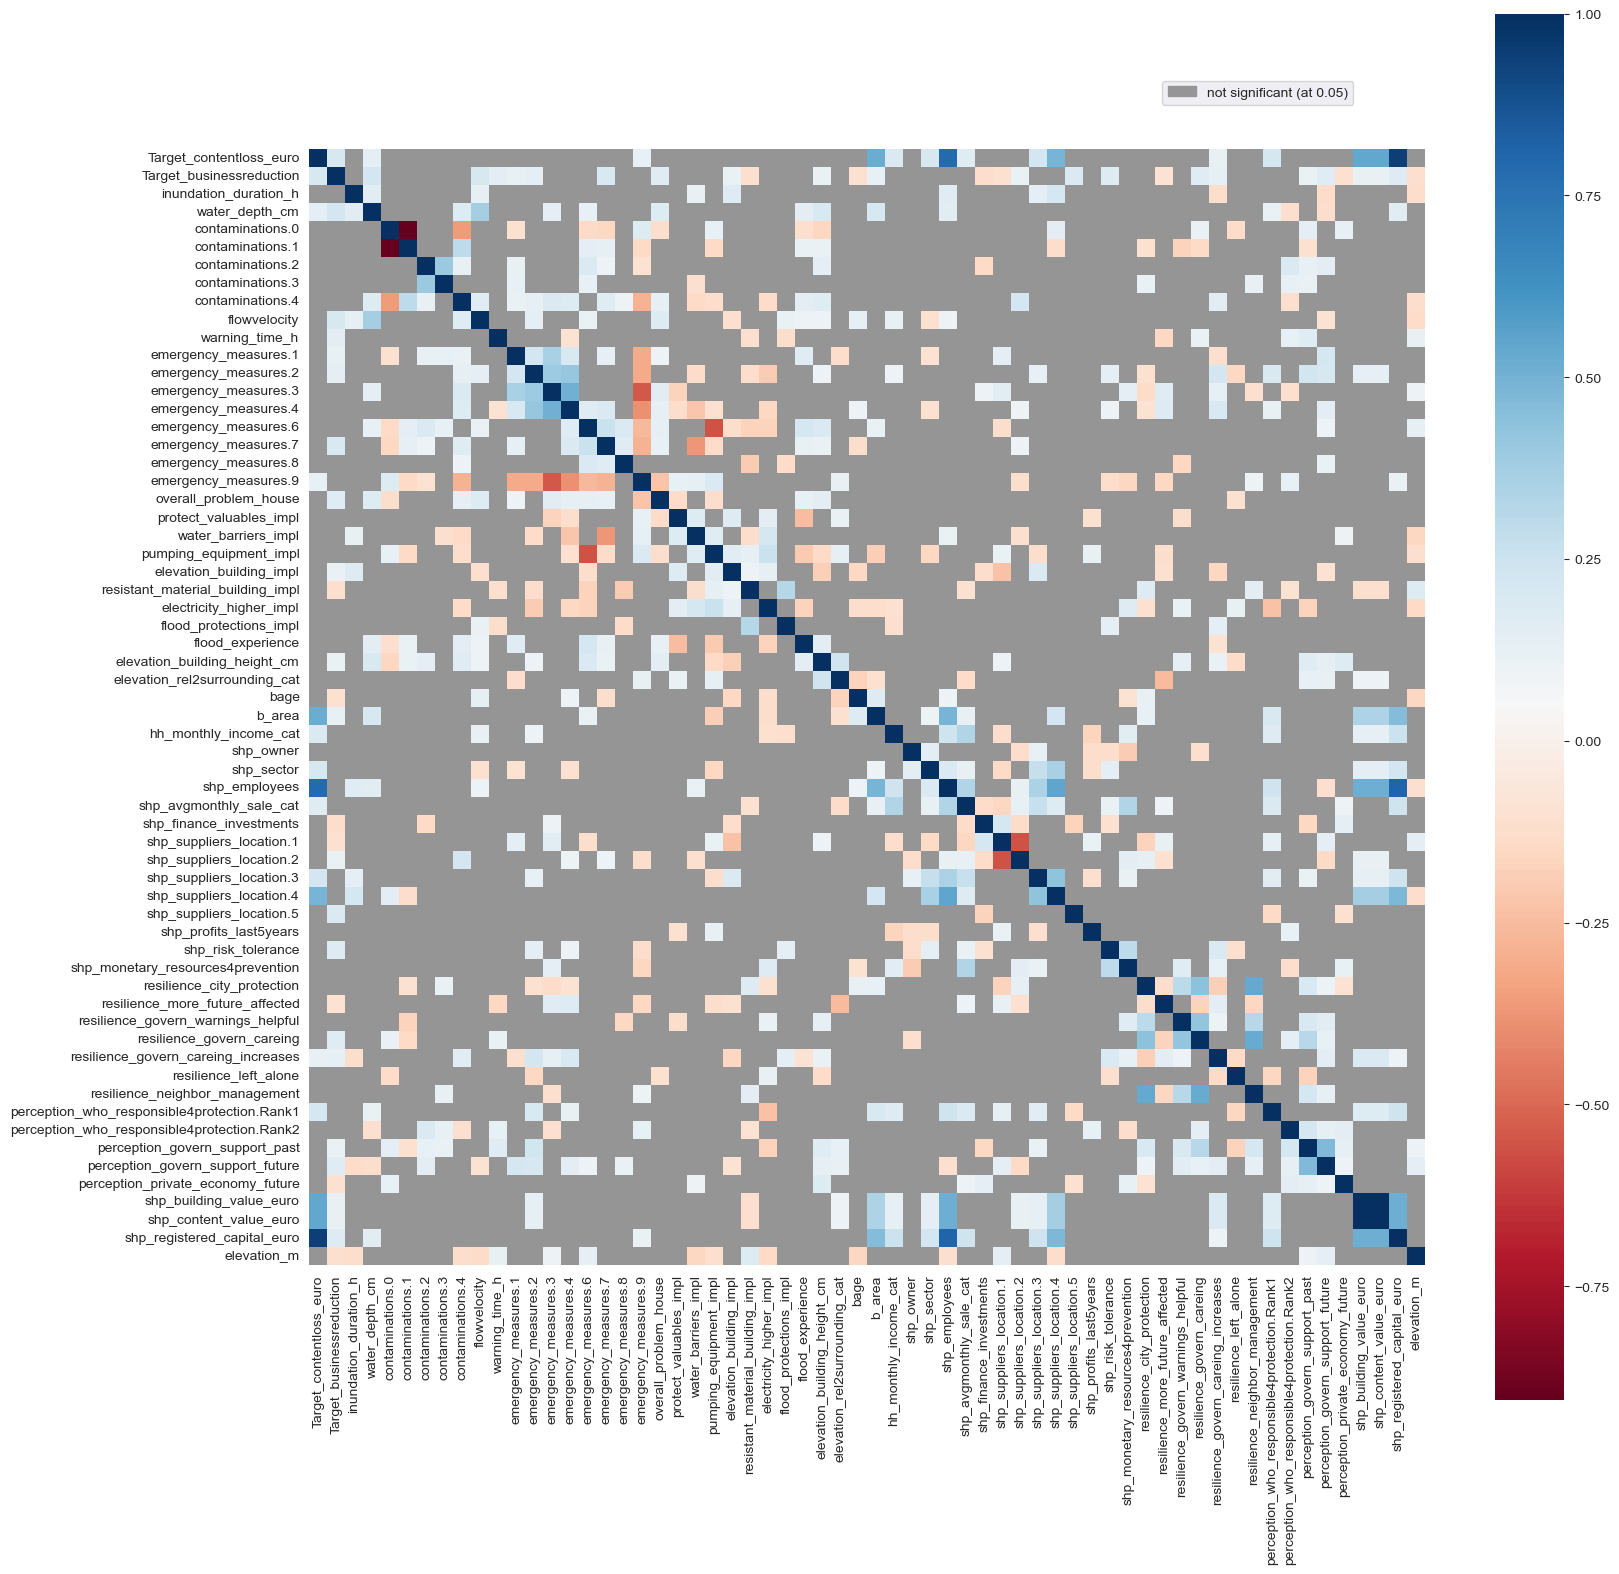

In [174]:
df_sm_corr = df_sm.drop(columns=['geometry', 'id', 'flood_year'], axis=1)
df_sm_corr = df_sm_corr.replace(np.nan, 0)

## None of the businesses has a insunrance either for the building or the shop
 
plot_pearsoncorrelation(df_sm_corr, signif=True, psig=0.1)



#### Summarize Pearson Corr Coefs
--> many predictors have not a signicant relationship to the target,- but this only for linear relationships
--> high corr (>0.8) between targets ~ [shp_closed_d, shp_duration_back2normal, shp_emplees, shp_capital_mVND]
--> Low corr coeffs between targets, for 
    emergency_measures, 
    private precautions in VND (eg. water-barriers, water-resistant material) - TODO check for implementations
    building_elevation_rel2surrounding
    warning_time_h
    building_floor
    shp_risk_behaviour
    shp_monetary_resources_prenvention
    --> replace them or combine them with PCA

--> TODO examine shp_damage_level_products low correlation to targets - why?

#### quantify mulitcollinearity


In [265]:
df_vif = pd.DataFrame()
df_vif["features"] = df_candidates_X.columns
df_candidates_X_filled = df_candidates_X.replace(np.nan, 0)
df_vif["vif_scores"] = [variance_inflation_factor(df_candidates_X_filled.values.astype(float), i)  for i in range(len(df_candidates_X_filled.columns))]
df_vif.sort_values("vif_scores", ascending=False)  
# VIF >5 : high correlation
# VIF 1-10: medium correlation


c:\Anaconda\envs\py396_c3\lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,features,vif_scores
69,perception_who_responsible4protection.Rank6,3.002400e+15
70,perception_who_responsible4protection.Rank7,2.797267e+13
43,resistant_material_building_impl,6.622076e+01
3,contaminations.1,6.186608e+01
45,flood_protections_impl,6.160794e+01
...,...,...
15,warning_type.5,1.706967e+00
16,warning_type.6,1.494031e+00
0,inundation_duration_h,1.468591e+00
19,warning_type.9,NaN


##### Summarize VIF scores
--> Pearson Corr Coeff shows bivariate correlation between one var ~ to another var
--> VIF shows Correlation between one var ~ group of other vars

--> precaution measures and shop size  (i.e. nmbr employees,registed capital )will probably inlfucnence the model predictions of damage costs.
--> multicollineary can decrease ML learning (matters only for Regressions). For RF it limits interpretability of used features, i.e. less expressive feature importance, due to redundancy of features  (esp. if only few trees were used) 

--> apply PCA to reduce dimensionality and to solve mulitcollinearity of some predictors (esp. for shp_closed_d, shp_duration_back2normal, shp_capital_mVND, shp_employees,	business_reduction_s, contaminations, shp_avgmonthly_sale_mVND business_reduction_r) or alternatively remove redundant variables , alternativly apply feature selection by e.g. Random Forests "feature importance"


In [ ]:
print( "Amount of missing vlaues or zeros per column in % to total number of data points.")
print("Note: Some are overestimated due that for some predictors zero means 'no' e.g. no monthly sale reduction (business_reduction) or no financal support for elevated building\n")
print(df_candidates_combined[df_candidates_combined == 0.0].count() / len(df_candidates_combined) *100)

## *_impl: did not implement precuation= 5

Amount of missing vlaues or zeros per column in % to total number of data points.
Note: Some are overestimated due that for some predictors zero means 'no' e.g. no monthly sale reduction (business_reduction) or no financal support for elevated building

Target_direct                              57.142857
business_reduction                         35.912698
inundation_duration_h                       1.984127
water_depth_cm                              0.000000
warning_time_h                             78.769841
shp_damage_level_furniture                  0.000000
shp_damage_level_electronics                0.000000
shp_damage_level_equipment                  0.000000
shp_damage_level_products                   0.000000
shp_damage_level_others                   100.000000
shp_closed_d                               56.150794
shp_duration_back2normal                   54.365079
contaminations                              0.000000
emergency_measures                          0.000000
Q0.1

### Overview: flood events, total costs of damages, business reduction, flood variables 

- select years of flood events
- compare occurence of floods with total direct costs for damages on business contents 


In [ ]:
df_candidates_combined.business_reduction.value_counts();


ValueError: x must be 1D

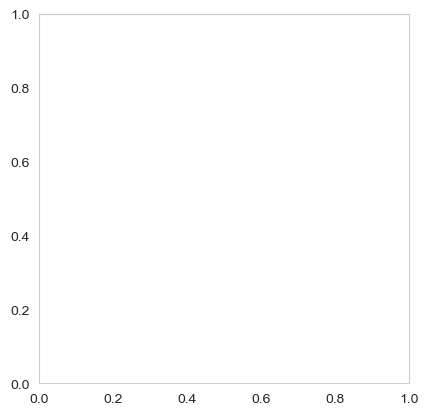

In [278]:
## visualize distribution for most importnat variable = business_reduction 

business_reduction_classes = df_candidates.business_reduction.groupby(pd.cut(
    df_candidates.business_reduction,  [-0.01, 0.01, 10.0, 25.0, 50.0, 75.0, 100.0],)
    #labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"])
    ).count()
business_reduction_classes = pd.DataFrame(business_reduction_classes)

#def pie_plot(df_column, x=df.columns() , labels=df):
plt.pie(x=df_candidates_X, labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"], data=business_reduction_classes)
#plt.legend(labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"], loc="best")
plt.title("monthly reduction due to flooding")

In [ ]:
#floods_years_s = pd.to_datetime(floods_time_rs["P1Q2.2.2"], errors='ignore', format='mixed')
df["flood_time_r"] = df["flood_time_r"].str.split(pat="/", expand=True)[2]  
df["flood_time_s"] = df["flood_time_s"].str.split(pat="/", expand=True)[2] 
df["flood_time_r"] = pd.to_datetime(df["flood_time_r"]).dt.strftime('%Y')
df["flood_time_s"] = pd.to_datetime(df["flood_time_s"]).dt.strftime('%Y')
df;



In [ ]:
# df.Target_direct_r  = df.Target_direct_r.replace(r'^,', '', regex=True)  # fix values beginning with random commas e.g. ,5
# df.Target_direct_r = df.Target_direct_r.astype(str).apply(lambda x: np.where(x.isdigit(), x, np.nan)) # set remaining errorneous values as nan e.g 1,5
# df.Target_direct_r = df.Target_direct_r.astype(float).astype(pd.Int64Dtype())
# df.Target_direct_r

# df.Target_direct_s  = df.Target_direct_s.replace(r'^,', '', regex=True)  # fix values beginning with random commas e.g. ,5
# df.Target_direct_s = df.Target_direct_s.astype(str).apply(lambda x: np.where(x.isdigit(), x, np.nan)) # set remaining errorneous values as nan e.g 1,5
# df.Target_direct_s = df.Target_direct_s.astype(float).astype(pd.Int64Dtype())


,protect_valuables_impl,water_barries_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl
0,5.0,3.0,5.0,4.0,5.0,5.0,5.0
1,5.0,5.0,3.0,4.0,5.0,3.0,5.0
2,5.0,5.0,5.0,5.0,5.0,3.0,5.0
3,5.0,5.0,3.0,1.0,5.0,5.0,5.0
4,5.0,5.0,5.0,2.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...
499,2.0,2.0,5.0,1.0,5.0,1.0,5.0
500,1.0,5.0,5.0,1.0,5.0,1.0,5.0
501,1.0,1.0,5.0,1.0,5.0,5.0,5.0
502,1.0,4.0,4.0,5.0,4.0,4.0,5.0


Text(0, 0.5, 'count')

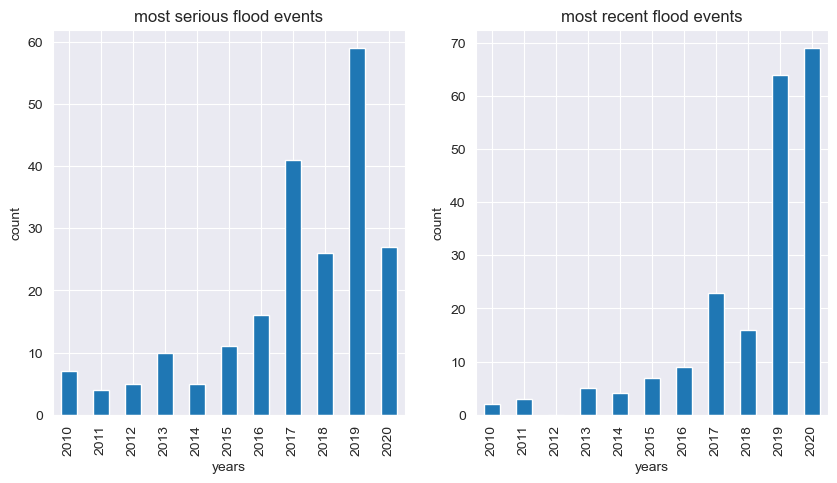

In [ ]:
## Timeline: flood events

floods_years_rs = pd.DataFrame({"most_serious": df["flood_time_s"].value_counts(),
       "most_recent": df["flood_time_r"].value_counts()})
floods_years_rs.index.name = "years"


fig, ax = plt.subplots(1,2, figsize=(10,5))

floods_years_rs.most_serious.plot.bar( ax=ax[0], title="most serious flood events")
floods_years_rs.most_recent.plot.bar( ax=ax[1], title="most recent flood events")
ax[0].set_ylabel("count")
ax[1].set_ylabel("count")


In [ ]:
sum(rfloods_by_year.loc["2018",:].sum())

6031.3

Text(0, 0.5, 'mVND, max= 6031.3 mVND')

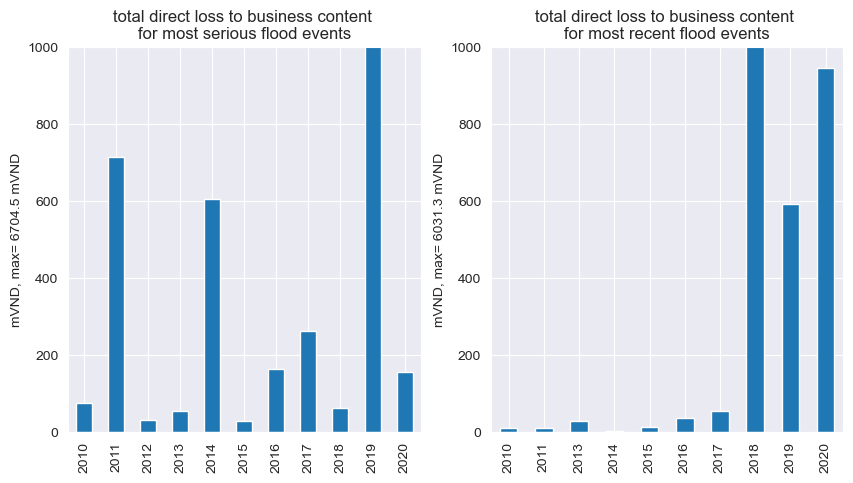

In [ ]:
## Timeline: Damage costs caused by floods

## TODO check if cost by year are correct - eg. Leitpold "total costs per secotr" - seems erroneous eg. 2011, 2019 with many flood events

df = df.sort_values('flood_time_r')
rfloods_by_year = df.groupby('flood_time_r')['Target_direct_r']
rfloods_by_year = pd.DataFrame(rfloods_by_year.apply(list).values).set_index(pd.DataFrame(rfloods_by_year)[0])
df = df.sort_values('flood_time_s')
sfloods_by_year = df.groupby('flood_time_s')['Target_direct_s']
sfloods_by_year = pd.DataFrame(sfloods_by_year.apply(list).values).set_index(pd.DataFrame(sfloods_by_year)[0])


fig, ax = plt.subplots(1,2, figsize=(10,5))
sfloods_by_year[0].apply(sum).plot.bar( title="total direct loss to business content \nfor most serious flood events", ax=ax[0]) # .astype("Int64")
rfloods_by_year[0].apply(sum).plot.bar( title="total direct loss to business content \nfor most recent flood events", ax=ax[1])
ax[0].set_ylabel("mVND")
ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[0].set_ylim([0,1000]) 
ax[0].set_ylabel(f"mVND, max= {sum(sfloods_by_year.loc['2019',:].sum())} mVND")
ax[1].set_ylim([0,1000])  #ax[1].set_yscale('log')
ax[1].set_ylabel(f"mVND, max= {sum(rfloods_by_year.loc['2018',:].sum())} mVND")


Text(0, 0.5, 'count')

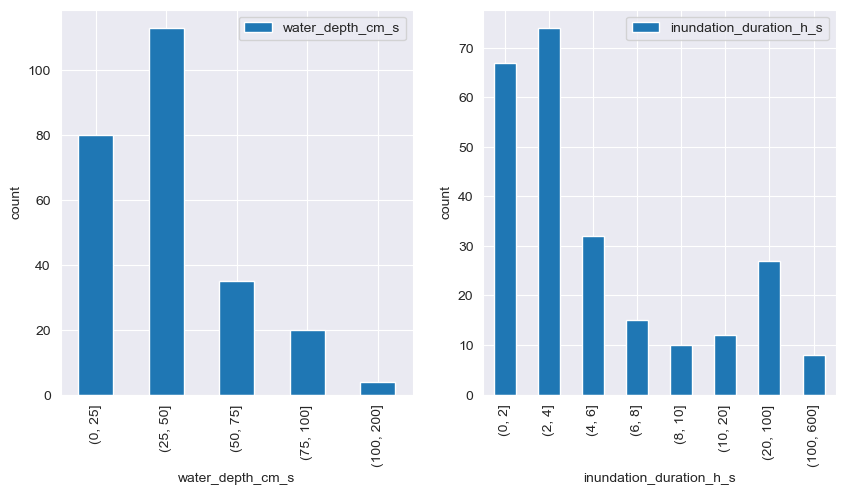

In [ ]:
## Timeline: flood variables for most serious flood events

# categorize continious flood variables
inundation_duration_classes = df_candidates.inundation_duration_h_s.groupby(pd.cut(df_candidates.inundation_duration_h_s, [0, 2, 4, 6, 8, 10, 20, 100, 600])).count()
water_depth_classes = df_candidates.water_depth_cm_s.groupby(pd.cut(df_candidates.water_depth_cm_s, [0, 25, 50, 75, 100, 200])).count()
inundation_duration_classes = pd.DataFrame(inundation_duration_classes)
water_depth_classes = pd.DataFrame(water_depth_classes)

fig, ax = plt.subplots(1,2, figsize=(10,5))
water_depth_classes.plot.bar( ax=ax[0])
inundation_duration_classes.plot.bar( ax=ax[1])
ax[0].set_ylabel("count")
ax[1].set_ylabel("count")

#### Summarize water depth and inundation duration

- both flood variables have not a gaussian distribution -> normaization is more suitable when uni- and bivariate stage-damage functions are applied by using the m as independend variables.

protect_valuables_impl  water_barries_impl  pumping_equipment_impl  elevation_building_impl  resistant_material_building_impl  electricity_higher_impl  flood_protections_impl
5.0                     5.0                 5.0                     4.0                      5.0                               5.0                      5.0                       32
                        3.0                 5.0                     4.0                      5.0                               5.0                      5.0                       16
3.0                     5.0                 5.0                     3.0                      5.0                               5.0                      5.0                       16
5.0                     5.0                 5.0                     2.0                      5.0                               5.0                      5.0                       14
                                                                    5.0                      5.0     

#### shp_damage_level_products_ + equipemtn + funiture

In [ ]:
#df_candidates_combined.shp_damage_level_products.value_counts(
df_candidates_combined.filter(regex="shp_damage_level")

,shp_damage_level_furniture,shp_damage_level_electronics,shp_damage_level_equipment,shp_damage_level_products,shp_damage_level_others,shp_damage_level_others_r.specify,shp_damage_level_others_s.specify
0,1.0,1.0,1.0,1.0,0.0,None,None
1,4.0,4.0,4.0,4.0,0.0,None,None
2,4.0,4.0,4.0,4.0,0.0,None,None
3,1.0,1.0,1.0,1.0,0.0,None,None
4,1.0,1.0,1.0,1.0,0.0,None,None
...,...,...,...,...,...,...,...
499,1.0,1.0,1.0,1.0,0.0,None,None
500,1.0,2.0,3.0,4.0,0.0,None,None
501,1.0,1.0,3.0,1.0,0.0,None,None
502,2.0,2.0,4.0,2.0,0.0,None,None


In [ ]:
df_candidates_combined.shp_damage_level_products.value_counts()
#.filter(regex="shp_damage_level")
# ## visualize distribution for most importnat variable = business_reduction 

business_reduction_classes = df_candidates_combined.shp_damage_level_products.groupby(pd.cut(
    df_candidates_combined.shp_damage_level_products, #list(df_candidates_combined.shp_damage_level_products.unique()+0.1))
    [0.0, 1.0, 2.0, 3.0, 4.0, 99.0],)
    #labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"])
    ).count()
business_reduction_classes = pd.DataFrame(business_reduction_classes)

plt.pie(x="shp_damage_level_products", data=business_reduction_classes, labels=list(df_candidates_combined.shp_damage_level_products.unique()))
#plt.legend(labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"], loc="best")
plt.title("damage levels to products")

AttributeError: 'DataFrame' object has no attribute 'shp_damage_level_products'

ValueError: 'label' must be of length 'x'

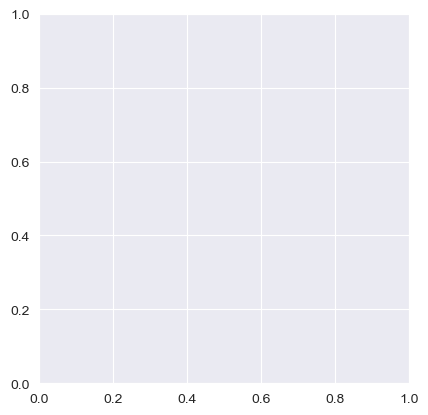

In [ ]:
business_reduction_classes = df_candidates_combined.shp_damage_level_equipment.groupby(pd.cut(
    df_candidates_combined.shp_damage_level_equipment, [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],)
    #labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"])
    ).count()
business_reduction_classes = pd.DataFrame(business_reduction_classes)

plt.pie(x="shp_damage_level_equipment", labels=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0], data=business_reduction_classes)
#plt.legend(labels=["no reduction", "1-10%", "10-25%", "25-50%", "50-75%", "75-100"], loc="best")
plt.title("damage levels to business buildings")

## Variable distribution
- types of businesses = DONE
- water depth and inundation duration = DONE
- educational level
- distribution and amount of obs for business disruptions [monthly reduction %] P1Q5.9
- target 1 : direct costs of losses for business contents [VND] DONE 


In [ ]:
df_candidates.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 26 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Target_direct_s                     247 non-null    Int64
 1   Target_direct_r                     246 non-null    Int64
 2   inundation_duration_h               252 non-null    Int64
 3   water_depth_cm                      252 non-null    Int64
 4   contaminations                      252 non-null    Int64
 5   warning_time_h                      252 non-null    Int64
 6   emergency_measures                  252 non-null    Int64
 7   protect_valuables_impl              252 non-null    Int64
 8   water_barries_impl                  252 non-null    Int64
 9   flood_protections_impl              252 non-null    Int64
 10  resistant_material_building_impl    252 non-null    Int64
 11  elevation_building_height_cm        252 non-null    Int64
 12  building

### Visual analysis of predictor and predicted variable distributions 

#### Summarize visual exploration of variable distribtuions
--> drop var: building_elevation2surrounding
--> mostly exponential distribution, sometimes gaussian distr.

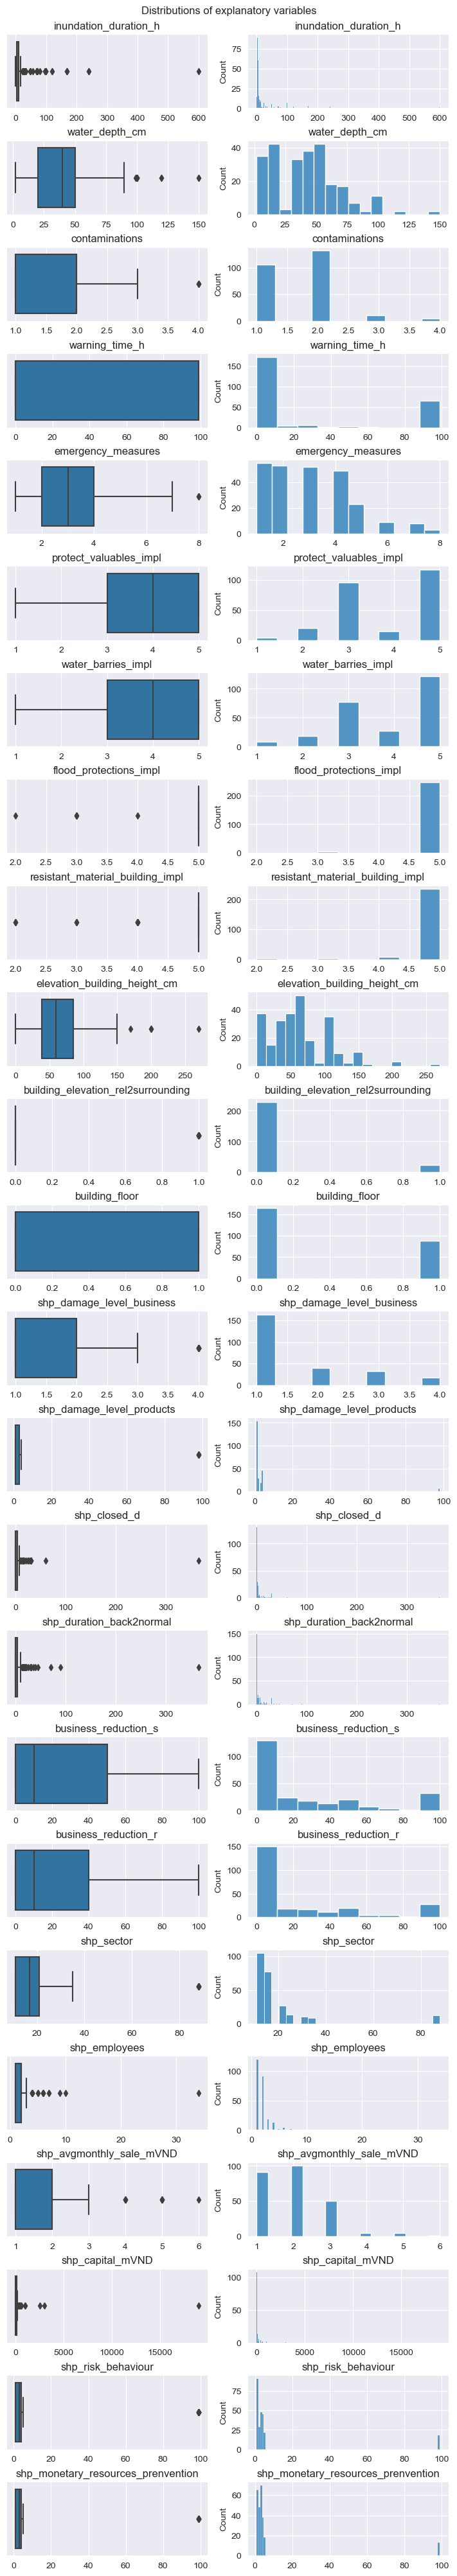

In [ ]:
#plt.figure(figsize=(58, 28))

fig, (ax_hist) = plt.subplots(len(df_candidates_X.columns), 2, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
#fig.tight_layout()  # alternative for tight_layout() and subplots_adjust(): constrained_layout=True
fig.suptitle('Distributions of explanatory variables')

for i, c in enumerate(df_candidates_X.columns[:]):
    #plt.subplots_adjust(hspace=.2)
    sns.boxplot(x=df_candidates_X[c].astype(float), ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    sns.histplot(x=df_candidates_X[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"


## TODO : shp_closed, shp_duration_back2normal, shp_damage_level from conitnous -> intervals

# sns.despine(ax=ax_hist)  # arrange boxplots above bar charts
# sns.despine(ax=ax_box, left=True)
# ax_box.set(yticks=[])


NameError: name 'df_candidates_Y' is not defined

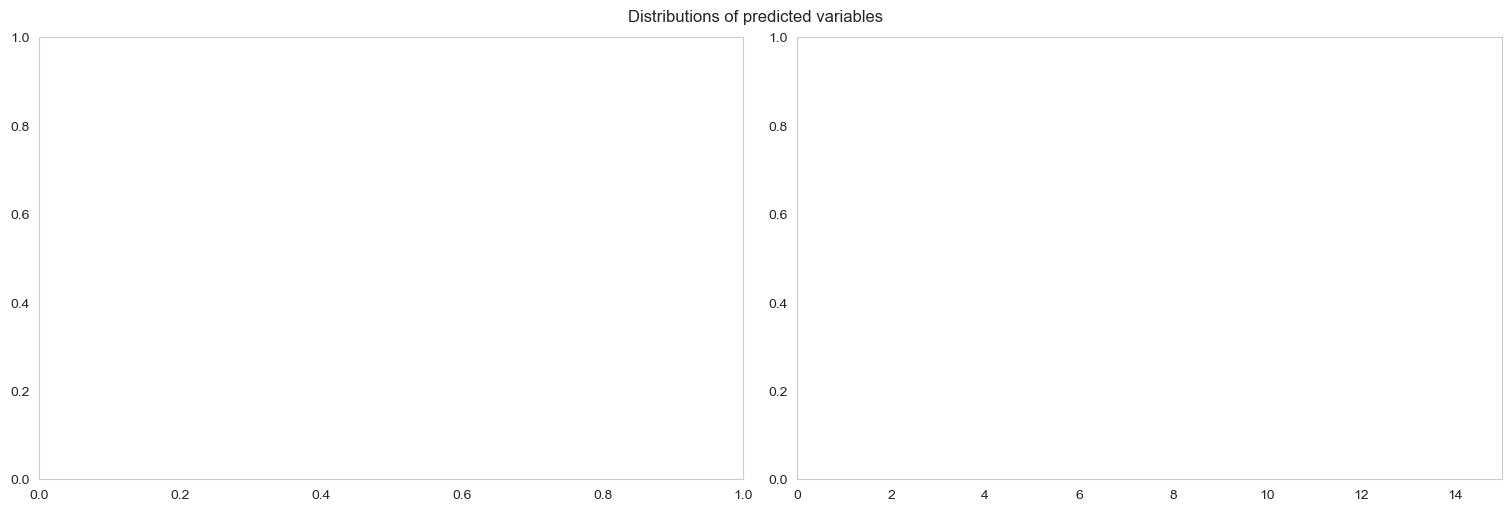

In [ ]:
def plot_boxplot_histogram(df):
    """
    todo make first multi plot -> than apply for only column
    df:

    return: combined boxplot and histograms 
    """
    fig, (ax_hist) = plt.subplots(len(df.columns), 2, sharex=False, figsize=(15, 5), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
    fig.suptitle('Distributions of predicted variables')
    plt.xlim(0, 15)
    for i, c in enumerate(df_candidates_Y.columns[:]):
        ax_hist[i,1].set_xlim(0,22)  # limit histoplot
        sns.boxplot(x=df[c].astype(float), showfliers=True, ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
        sns.histplot( x=df[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c} - excluded outliers", xlabel=None) #  stat='count', errorbar=("pi", 95), # stat='count', log_scale=True #.set(title=c) # bins=12, stat="percent"
        #sns.countplot(df_candidates_Y[c].astype(float).astype('Int64'), ax=ax_hist[i, 1])  # discrete=False,


    # fig, (ax_hist) = plt.subplots(len(df_targets), 2, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
    # #f ig.tight_layout()  # alternative for tight_layout() and subplots_adjust(): constrained_layout=True
    # fig.suptitle(f'Distributions of {df_targets.columns}')

    # for i, c in enumerate(df_targets.columns[:]):
    #     #plt.subplots_adjust(hspace=.2)
    #     sns.boxplot(x=df_targets[c].astype(float), ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    #     sns.histplot(x=df_targets[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"


plot_boxplot_histogram(df=df_targets)

## TODO : shp_closed, shp_duration_back2normal, shp_damage_level from conitnous -> intervals

# sns.despine(ax=ax_hist)  # arrange boxplots above bar charts
# sns.despine(ax=ax_box, left=True)
# ax_box.set(yticks=[])


#### Target distributions


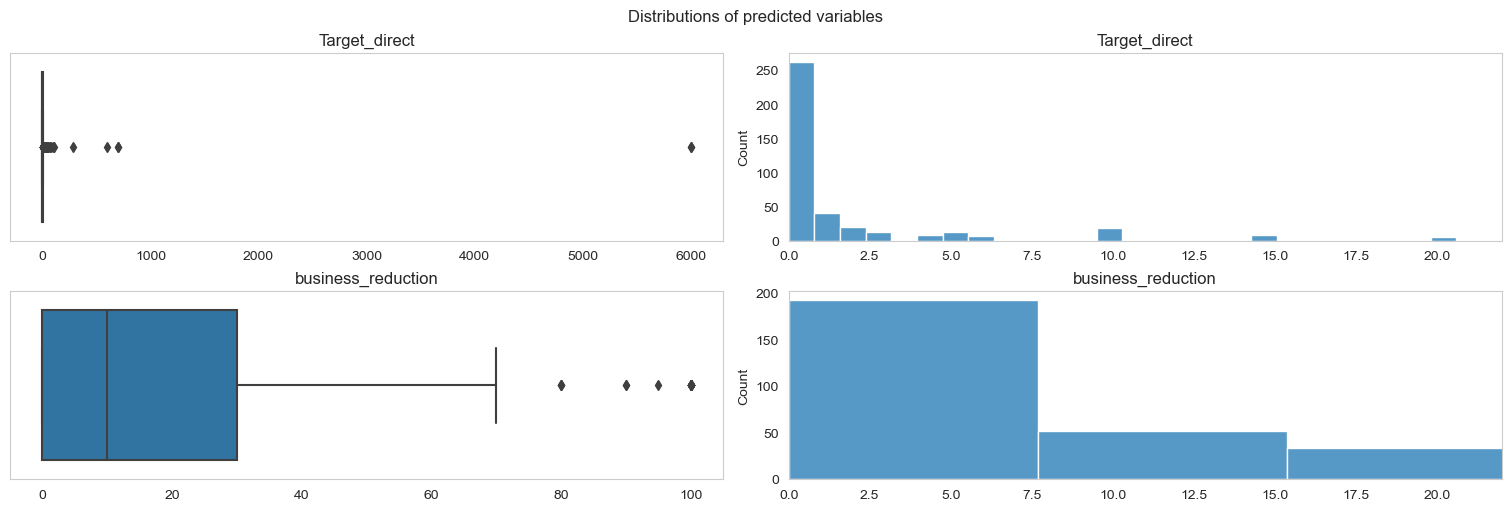

In [275]:

#plt.figure(figsize=(10, 28))

#def pie_charts():
fig, (ax_hist) = plt.subplots(len(df_candidates_y.columns), 2, sharex=False, figsize=(15, 5), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
fig.suptitle('Distributions of predicted variables')
plt.xlim(0, 15)

for i, c in enumerate(df_candidates_y.columns[:]):
    ax_hist[i,1].set_xlim(0,22)  # limit histoplot
    sns.boxplot(x=df_candidates_y[c].astype(float), showfliers=True, ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    sns.histplot( x=df_candidates_y[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) #  stat='count', errorbar=("pi", 95), # stat='count', log_scale=True #.set(title=c) # bins=12, stat="percent"
    #sns.countplot(df_candidates_Y[c].astype(float).astype('Int64'), ax=ax_hist[i, 1])  # discrete=False,



In [47]:
busin_direct_closses = df_candidates_y.business_reduction[df_candidates_y.business_reduction >=0.1]

#df_candidates_y.business_reduction.isna().sum()
print(df_candidates_y.Target_direct.isna().sum(), "Businesses didnt provide information")
print(df_candidates_y.Target_direct[df_candidates_y.Target_direct <=0.1].count(), "Business had no content losses")
print(df_candidates_y.Target_direct[df_candidates_y.Target_direct >=100.0].count(), "Business had content loss higher than 100 mVND")

4 Businesses didnt provide information
251 Business had no content losses
7 Business had content loss higher than 100 mVND


[Text(0.5, 1.0, 'reduce in monthly sale and production'),
 Text(0, 0.5, 'number businesses'),
 Text(0.5, 0, 'monthly reduction [%/month]')]

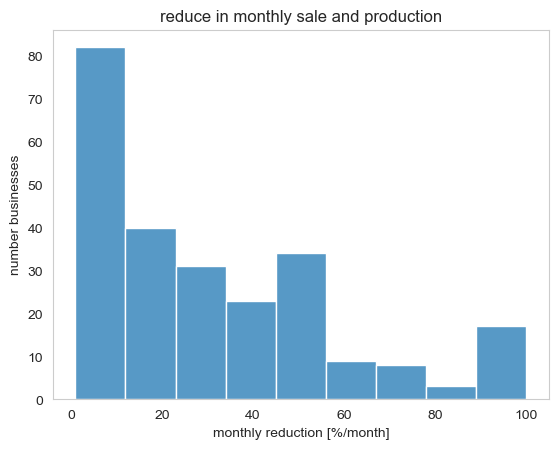

In [44]:

fig, ax = plt.subplots()
#ax.set_ylim(0,1200)
#sns.boxplot(x=busin_direct_closses, showfliers=True).set(title=f"{c}", xlabel=None)
sns.histplot(data=busin_direct_closses, stat='count').set(title=f"reduce in monthly sale and production", ylabel="number businesses", xlabel="monthly reduction [%/month]") #  stat='count', errorbar=("pi", 95), # stat='count', log_scale=True #.set(title=c) # bins=12, stat="percent"
#ax.set_xlim(0,100)


- PLOT Distrib -  Target_r, Target_s  with removed dublicated cases	
- PLOT Distrb+ anteil an precaution meausres == nan++not impl --> check einfluss auf damage costs in VIF/pearson -beide wichtigsten VARs impl in bivariate func
- PLOT distrib plot shop_damage_levels (funriture, electronic, spec equipment, products)


##### precautionary measures vs target

In [55]:
d = df_candidates.filter(regex="_impl",axis=1)
d.elevation_building_impl.value_counts()

elevation_building_impl
1.0    149
4.0    132
5.0     62
2.0     37
Name: count, dtype: int64

NameError: name 'df_candidates_Y' is not defined

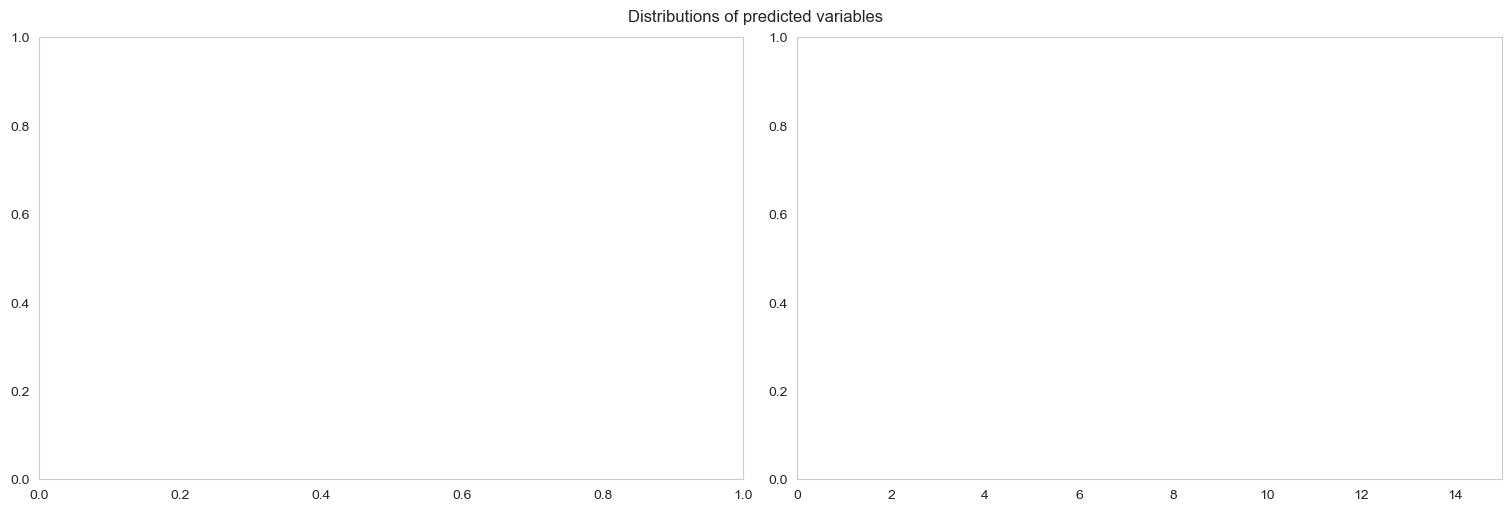

In [ ]:
def plot_boxplot_histogram(df):
    """
    todo make first multi plot -> than apply for only column
    df:

    return: combined boxplot and histograms 
    """
    fig, (ax_hist) = plt.subplots(len(df.columns), 2, sharex=False, figsize=(15, 5), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
    fig.suptitle('Distributions of predicted variables')
    plt.xlim(0, 15)
    for i, c in enumerate(df_candidates_Y.columns[:]):
        ax_hist[i,1].set_xlim(0,22)  # limit histoplot
        sns.boxplot(x=df[c].astype(float), showfliers=True, ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
        sns.histplot( x=df[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c} - excluded outliers", xlabel=None) #  stat='count', errorbar=("pi", 95), # stat='count', log_scale=True #.set(title=c) # bins=12, stat="percent"
        #sns.countplot(df_candidates_Y[c].astype(float).astype('Int64'), ax=ax_hist[i, 1])  # discrete=False,


    # fig, (ax_hist) = plt.subplots(len(df_targets), 2, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
    # #f ig.tight_layout()  # alternative for tight_layout() and subplots_adjust(): constrained_layout=True
    # fig.suptitle(f'Distributions of {df_targets.columns}')

    # for i, c in enumerate(df_targets.columns[:]):
    #     #plt.subplots_adjust(hspace=.2)
    #     sns.boxplot(x=df_targets[c].astype(float), ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    #     sns.histplot(x=df_targets[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"


plot_boxplot_histogram(df=df_targets)

## TODO : shp_closed, shp_duration_back2normal, shp_damage_level from conitnous -> intervals

# sns.despine(ax=ax_hist)  # arrange boxplots above bar charts
# sns.despine(ax=ax_box, left=True)
# ax_box.set(yticks=[])


#### contamination types 


39  businesses reported that they had no  contaminated water


Text(0.5, 1.0, 'Contamination types: \nContamination with fuel oil occures 13 times')

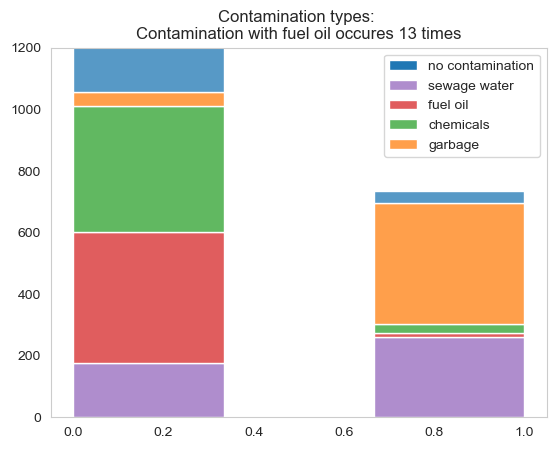

In [379]:
fig, ax = plt.subplots()
d = df_candidates.filter(regex="contamination",axis=1)
#d = d.drop(["contaminations.99", "contaminations.88"], axis=1)
sns.histplot(bins=3, data=d, multiple="stack")
#d = d.replace(r'^,', '0.', regex=True) 
#d = d.replace(',', '.') 
#sns.histplot(data=d)

#ax.set_yscale('log')
ax.set_ylim(0,1200)
ax.set_ylabel("")
ax.legend(['no contamination', 'sewage water', 'fuel oil', 'chemicals', 'garbage'], loc="best")

print(df_candidates["contaminations.0"].value_counts()[1], " businesses reported that they had no  contaminated water")
ax.set_title(f"Contamination types: \nContamination with fuel oil occures {df_candidates['contaminations.3'].value_counts()[1]} times")


In [292]:
contamination_types

,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,freq
0,0,1,0,0,1,230
1,0,1,0,0,0,130
2,1,0,0,0,0,39
3,0,1,1,0,1,17
4,0,1,1,1,1,7
5,0,0,0,0,1,5
6,0,1,1,0,0,3
7,0,1,0,1,0,2
8,0,1,0,1,1,2
9,0,1,1,1,0,2


In [50]:
contamination_types = df_candidates.filter(regex="^contamination", axis=1)#shp_sector[df['shp_sector'] < 20]
#shop_types = df[(df['shp_sector'] >= 10) & (df['shp_sector'] < 20)]
contamination_types = contamination_types.value_counts().reset_index(name='freq')
#contamination_types["contamination_type"] = contamination_types#.replace([11, 12, 13, 14, 15, 16, 17],["food", "fashion", "houseware", "construction", "electicity", "pharmacy", "others"])
print(df_candidates["contaminations.0"].value_counts()[1], " businesses reported that they had no contaminated water")


# shop_types = df.shp_sector[df['shp_sector'] < 20]
# #shop_types = df[(df['shp_sector'] >= 10) & (df['shp_sector'] < 20)]
# shop_types = shop_types.value_counts().reset_index(name='shop_freq')
# shop_types["shop_type"] = shop_types.shp_sector.replace([11, 12, 13, 14, 15, 16, 17],["food", "fashion", "houseware", "construction", "electicity", "pharmacy", "others"])

# plt.pie(x="shop_freq", labels="shop_type", data=shop_types)
# plt.legend(shop_types.shop_type, loc="best")
# plt.title("business sectors for shops")
# plt.axis('equal')
# plt.tight_layout()
# plt.show()


# plt.pie(x="shop_freq", labels="shop_type", data=shop_types)
# plt.legend(shop_types.shop_type, loc="best")
# plt.title("business sectors for shops")
# plt.axis('equal')
# plt.tight_layout()
# plt.show()

df_candidates


39  businesses reported that they had no  contaminated water


,Target_direct,business_reduction,flood_time,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.5,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house.1,overall_problem_house.2,overall_problem_house.3,overall_problem_house.4,overall_problem_house.5,overall_problem_house.6,overall_problem_house.7,overall_problem_house.8,overall_problem_house.9,same,protect_valuables_impl,water_barries_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,rloss,bloss,lu_cert,building_value,building_area,bage,bage_ren,shp_closed_d,household_inhabitants_number,people_com,household_education,poverty_cert,household_monthly_income_mVND,shp_sector,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increasing,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_who_responsible4protection.Rank3,perception_who_responsible4protection.Rank4,perception_who_responsible4protection.Rank5,perception_who_responsible4protection.Rank6,perception_who_responsible4protection.Rank7,perception_who_responsible4protection.Rank88,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,id,elevation_m,lon,lat,geometry
0,0.0,10.0,2020-09-01,1.0,50.0,0,1,0,0,0,3,NaN,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,False,4.0,5.0,5.0,1.0,5.0,1.0,5.0,6,0.000000,0.0,1.0,800.0,156.0,45.0,45.0,0.0,8,1,4.0,0,3.0,11,5.0,3.0,2.0,4.0,1.0,3,4.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,3.0,0.0,1.40,10.724409,106.602300,POINT (106.60230 10.72441)
1,4.0,5.0,2016-12-01,1.0,10.0,0,1,0,0,1,2,NaN,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,False,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5,1.000000,600000000.0,1.0,600.0,118.0,18.0,18.0,2.0,4,0,5.0,0,4.0,17,2.0,1.0,1.0,1.0,1.0,5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,1.61,10.733775,106.608990,POINT (106.60899 10.73377)
2,0.0,0.0,2013-10-01,1.0,30.0,0,1,0,0,1,3,NaN,1,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0.108333,65000000.0,1.0,600.0,114.0,1.0,1.0,1.0,5,0,4.0,0,4.0,13,1.0,2.0,1.0,2.0,2.0,4,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,2.0,1.47,10.824286,106.733150,POINT (106.73315 10.82429)
3,0.0,NaN,2020-08-15,1.0,1.0,0,1,0,0,0,1,1.0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,False,1.0,5.0,5.0,1.0,5.0,5.0,5.0,3,0.000000,0.0,1.0,4000.0,27.0,6.0,3.0,0.0,3,0,4.0,1,3.0,11,2.0,5.0,1.0,1.0,3.0,5,3.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0,3.0,1.09,10.726964,106.629986,POINT (106.62999 10.72696)
4,10.0,35.0,2020-08-01,1.0,30.0,0,0,0,0,1,2,NaN,1,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,False,1.0,5.0,5.0,1.0,5.0,1.0,5.0,5,0.012500,10000000.0,1.0,800.0,350.0,18.0,8.0,2.0,4,0,5.0,0,3.0,17,5.0,NaN,5.0,5.0,NaN,5,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.10,10.721289,106.632836,POINT (106.63284 10.72129)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.0,0.0,2019-09-01,0.5,10.0,1,0,0,0,0,1,NaN,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,False,1.0,1.0,5.0,1.0,5.0,1.0,5.0,5,0.000000,0.0,1.0,200.0,70.0,14.0,2.0,0.0,5,0,5.0,0,2.0,22,2.0,2.0,2.0,2.0,3.0,5,3.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,3.0,247.0,1.95,10.705101,106.688031,POINT (106.68803 10.70510)
438,1.0,10.0,2020-08-06,0.5,10.0,0,1,0,0,0,2,NaN,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,False,5.0,5.0,5.0,1.0,5.0,5.0,5.0,1,0.000000,0.0,1.0,500.0,35.0,45.0,45.0,2.0,4,0,8

#### Contamination vs water depth

In [449]:
contamination_types = df_candidates.filter(regex="^contamination", axis=1)


df_conta_wd = pd.concat([contamination_types, df_candidates.water_depth_cm], axis=1)
df_conta_wd.head(2)#.contaminations.value_counts()
df_conta_wd = df_conta_wd.melt(id_vars=['water_depth_cm'], value_vars=['contaminations.0', 'contaminations.1', 'contaminations.2', 'contaminations.3', 'contaminations.4'])
df_conta_wd = df_conta_wd[df_conta_wd.value==1]
df_conta_wd#.water_depth_cm.value_counts()
#df_conta_wd["variable"] = 
df_conta_wd["variable"].replace({'contaminations.0':'had no contamination', 
             'contaminations.1':'sewage water', 
             'contaminations.2':'fuel oil', 
             'contaminations.3':'chemicals', 
             'contaminations.4':'garbage'},  inplace=True)
df_conta_wd

,water_depth_cm,variable,value
21,2.0,had no contamination,1
33,15.0,had no contamination,1
35,10.0,had no contamination,1
44,3.0,had no contamination,1
57,10.0,had no contamination,1
...,...,...,...
2198,70.0,garbage,1
2202,50.0,garbage,1
2203,150.0,garbage,1
2204,20.0,garbage,1


In [370]:
contamination_types = pd.melt(df_candidates.filter(regex="^contamination", axis=1))
contamination_types = contamination_types[contamination_types.value==1]
#contamination_types = df_candidates.filter(regex="^contamination", axis=1)
contamination_types;
# #df_candidates.loc[:, 

# #df_candidates["contaminations.4"].value_counts() # 39, 45, 30, 13, .4=261
# #

Text(0.5, 0, 'water_depth_cm')

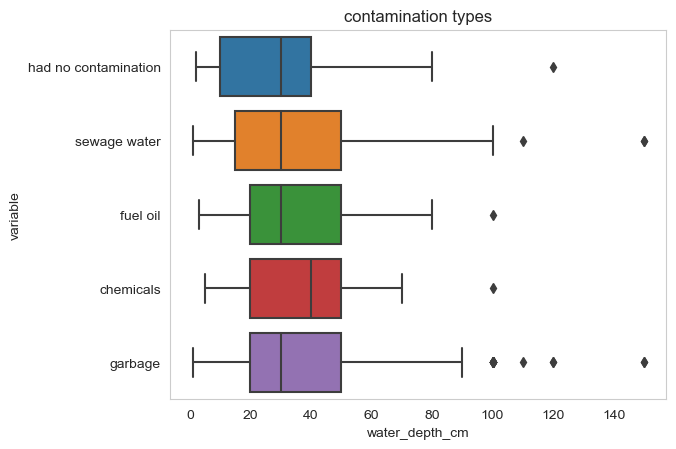

In [451]:
fig, ax = plt.subplots()

sns.boxplot(x="water_depth_cm", y= "variable", data=df_conta_wd).set(title=f"contamination types", xlabel=None) # ax=ax_hist[i, 0]
ax.set_xlabel("water_depth_cm")
#ax.set_xlim(0,200)
#x="variable", y="value", data=pd.melt(df))
# sns.boxplot(data=df, x="age", y="class")


#### precaution measures 


In [ ]:
df_candidates_combined.filter(regex="_impl").value_counts()  # 5=didnt implented , 99=dont know

#### business types 
grouped by their parent sector


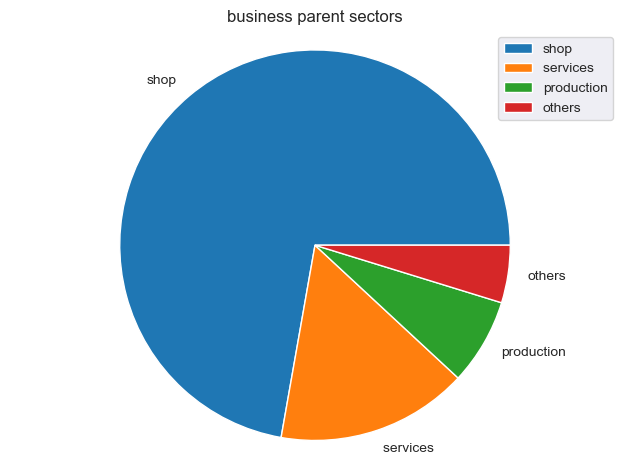

In [ ]:
bins =  np.arange(10, 90, 10)  # business sectors
ind = np.digitize(df['shp_sector'], bins)
 
shp_sectors = df.shp_sector.groupby(ind).value_counts().reset_index(name='sector_freq')
shp_sectors = shp_sectors.groupby("level_0")['sector_freq'].sum().reset_index()
#shp_sectors.shp_sector = shp_sectors.shp_sector.replace([11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 31, 32, 33, 34, 35, 88],["food","fashion", "houseware"])

shp_sectors["sectors"] = shp_sectors.level_0.replace([1, 2, 3, 8],["shop", "services ", "production", "others"])

plt.pie(x="sector_freq", labels="sectors", data=shp_sectors)
plt.legend(shp_sectors.sectors, loc="best")
plt.title("business sectors")
plt.axis('equal')
plt.tight_layout()
plt.show()

##### business types of shops

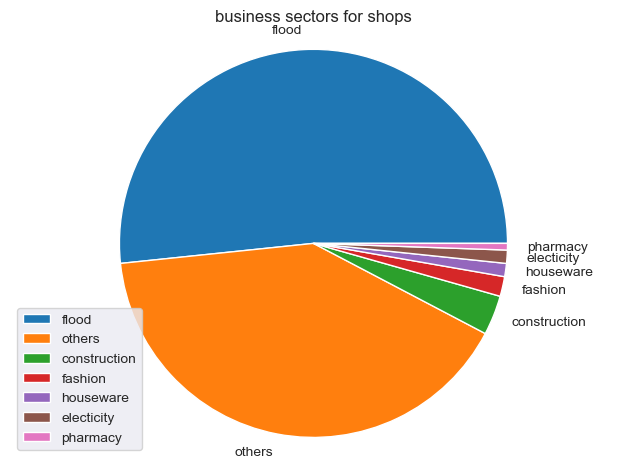

In [ ]:
shop_types = df.shp_sector[df['shp_sector'] < 20]
#shop_types = df[(df['shp_sector'] >= 10) & (df['shp_sector'] < 20)]
shop_types = shop_types.value_counts().reset_index(name='shop_freq')
shop_types["shop_type"] = shop_types.shp_sector.replace([11, 12, 13, 14, 15, 16, 17],["food", "fashion", "houseware", "construction", "electicity", "pharmacy", "others"])

plt.pie(x="shop_freq", labels="shop_type", data=shop_types)
plt.legend(shop_types.shop_type, loc="best")
plt.title("business sectors for shops")
plt.axis('equal')
plt.tight_layout()
plt.show()


### Statistics of variable distributions
mean, SD, amount of NAN

In [594]:
df_stats =pd.DataFrame(index=df_candidates.columns)

for c in df_candidates.columns.drop(["flood_time", "lat", "lon", "geometry"]):
    df_stats.loc[c, "min"] = df_candidates[c].min()
    df_stats.loc[c, "max"] = df_candidates[c].max()
    df_stats.loc[c, "mean"] = df_candidates[c].mean()#.round(2)
    df_stats.loc[c, "median"] = df_candidates[c].median()
    df_stats.loc[c, "sd"] = df_candidates[c].std()#.round(2)
    df_stats.loc[c, "no_value"] = df_candidates[c].isin([0, 99]).sum() | df_candidates[c].isna().sum()

print(df_stats.head(30))    


                         min     max       mean  median          sd  no_value
Target_direct            0.0  6000.0  36.630822     0.0  408.423207     255.0
business_reduction       0.0   100.0  19.624691    10.0   25.770260     191.0
flood_time               NaN     NaN        NaN     NaN         NaN       NaN
inundation_duration_h    0.2   600.0  13.156351     3.0   40.915054       9.0
water_depth_cm           1.0   150.0  35.315193    30.0   26.139190       1.0
contaminations.0         0.0     1.0   0.088235     0.0    0.283958     403.0
contaminations.1         0.0     1.0   0.895928     1.0    0.305700      46.0
contaminations.2         0.0     1.0   0.070136     0.0    0.255665     411.0
contaminations.3         0.0     1.0   0.029412     0.0    0.169149     429.0
contaminations.4         0.0     1.0   0.599548     1.0    0.490545     177.0
flowvelocity             1.0     5.0   3.022624     3.0    1.279326       0.0
warning_time_h           0.5    60.0   7.870000     1.0   13.962

c:\Anaconda\envs\py396_c3\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


#### Summarize quantitative exploration of variable distribtuions
--> warning_time_h and elevation rel2surounding have more than 200 entires missing (total 252 obs), therefore these variabels should be combined with other variables to a new variable (PCA) or should be excluded from feature space